# LSTM (Long Short-Term Memory) の実装

このノートブックでは、リカレントニューラルネットワーク（RNN）の重要なバリエーションであるLong Short-Term Memory (LSTM) のアーキテクチャと動作原理を学びます。
まず、単純なRNNが抱える長期依存性の問題を概観し、次にLSTMがその問題をどのように解決しようとしているのか、その中核となるゲート機構とセル状態について解説します。
NumPyを使ってLSTMセルの主要な計算ステップを実装し、その後PyTorchの`nn.LSTM`モジュールを使ってより簡単にLSTMモデルを構築し、学習させる方法を示します。

**参考論文:**
*   Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. *Neural computation*, 9(8), 1735-1780.
*   Werbos, P. J. (1990). Backpropagation through time: what it does and how to do it. *Proceedings of the IEEE*, 78(10), 1550-1560. (BPTTの背景として)

**このノートブックで学ぶこと:**
1.  単純なRNNにおける長期依存性学習の課題（勾配消失・爆発問題）。
2.  LSTMのアーキテクチャ：セル状態、忘却ゲート、入力ゲート、出力ゲート。
3.  NumPyによるLSTMセルの順伝播計算の実装。
4.  PyTorchの `nn.LSTM` モジュールを使ったLSTMモデルの実装。
5.  簡単なシーケンス予測タスクでの学習と評価。

**前提知識:**
*   Simple Recurrent Network (SRN) とBPTTの基本的な理解（前のノートブック）。
*   PyTorchの基本的な使い方。

 ## 1. 必要なライブラリのインポート

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

print(f"NumPy Version: {np.__version__}")
print(f"PyTorch Version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

NumPy Version: 1.26.4
PyTorch Version: 2.7.0+cpu
Using device: cpu


## 2. 単純なRNNの課題: 長期依存性と勾配問題

前のノートブックでSRNとBPTTについて学びました。SRNは理論上、任意の長さのシーケンス情報を扱える可能性がありますが、実際には**長期依存性 (long-term dependencies)** の学習が非常に困難です。これは主に、BPTTにおける**勾配消失 (vanishing gradient)** または**勾配爆発 (exploding gradient)** 問題に起因します。

*   **勾配消失:** 時間を遡って勾配を伝播させる際、活性化関数の微分値（SigmoidやTanhでは1未満になることが多い）やリカレント重みが繰り返し乗算されるため、勾配が指数関数的に小さくなり、過去の遠い情報が現在の学習にほとんど影響を与えなくなる問題。
*   **勾配爆発:** 逆に、リカレント重みが大きい場合などに勾配が指数関数的に増大し、学習が不安定になる問題（これは勾配クリッピングである程度対処可能）。

これらの問題のため、単純なRNNは数ステップ程度の短い依存関係しか捉えられないことが多いです。

## 3. LSTM (Long Short-Term Memory) の導入

LSTMは、HochreiterとSchmidhuber (1997) によって、この長期依存性問題を解決するために提案されたRNNの改良版です。その核心は、**セル状態 (cell state)** と呼ばれる情報を長期的に保持するための経路と、その情報の流れを制御するための3つの**ゲート (gate)** 機構にあります。

### 3.1 LSTMセルの構造

LSTMセルは、時刻 $t$ において以下の主要なコンポーネントを持ちます。

*   **入力 ($x_t$):** 時刻 $t$ の外部入力。
*   **前時刻の隠れ状態 ($h_{t-1}$):** 1つ前のLSTMセルからの出力（短期記憶）。
*   **前時刻のセル状態 ($C_{t-1}$):** 1つ前のLSTMセルから引き継がれる長期記憶。
*   **忘却ゲート ($f_t$):** 前時刻のセル状態 $C_{t-1}$ からどの情報を「忘れる」かを決定します。
*   **入力ゲート ($i_t$):** 新しい入力 $x_t$ と前時刻の隠れ状態 $h_{t-1}$ から、どの新しい情報を現在のセル状態に追加するかを決定します。
*   **候補セル状態 ($\tilde{C}_t$):** 入力ゲートによって選別される前の、新しい情報の候補。
*   **出力ゲート ($o_t$):** 更新されたセル状態 $C_t$ から、どの情報を隠れ状態 $h_t$ として出力するかを決定します。
*   **現時刻のセル状態 ($C_t$):** 忘却ゲートと入力ゲートによって更新された長期記憶。
*   **現時刻の隠れ状態 ($h_t$):** LSTMセルの出力であり、次のセルへの短期記憶として渡されます。

### 3.2 LSTMセルの計算ステップ (順伝播)

時刻 $t$ におけるLSTMセルの計算は、以下のステップで行われます（$\sigma$ はSigmoid関数、$\tanh$ はハイパボリックタンジェント関数）。

1.  **忘却ゲート ($f_t$):**  
    $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$  
    このゲートは、$h_{t-1}$ と $x_t$ を結合したものに入力を受け、0から1の間の値を出力します。1に近いほど情報を保持し、0に近いほど情報を忘れます。

2.  **入力ゲート ($i_t$) と候補セル状態 ($\tilde{C}_t$):**  
    $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$  
    $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$  
    入力ゲート $i_t$ は、どの新しい情報をセル状態に更新するかを決定します。候補セル状態 $\tilde{C}_t$ は、新しい情報の候補を生成します。

3.  **セル状態の更新 ($C_t$):**  
    $C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$  
    ここで $\odot$ は要素ごとの積（アダマール積）です。  
    *   $f_t \odot C_{t-1}$: 前のセル状態から忘却ゲートによって選ばれた情報を保持。
    *   $i_t \odot \tilde{C}_t$: 入力ゲートと候補セル状態から、新しい情報をスケーリングして追加。
    このセル状態 $C_t$ は、比較的変化が少なく、情報が長期にわたり保持されやすい構造になっています。これがLSTMの「コンスタントエラーカルーセル(CEC)」の核となる部分です。

4.  **出力ゲート ($o_t$) と隠れ状態の更新 ($h_t$):**  
    $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$  
    $h_t = o_t \odot \tanh(C_t)$  
    出力ゲート $o_t$ は、更新されたセル状態 $C_t$ のうち、どの部分を隠れ状態 $h_t$ として出力するかを決定します。セル状態 $C_t$ は $\tanh$ を通して (-1, 1) の範囲に調整されてから、出力ゲートによってフィルタリングされます。

**パラメータ:**
LSTMセルの学習可能なパラメータは、各ゲートと候補セル状態の計算に使われる重み行列 ($W_f, W_i, W_C, W_o$) とバイアスベクトル ($b_f, b_i, b_C, b_o$) です。

**なぜLSTMは長期依存性を捉えやすいのか？**
*   **セル状態:** 比較的単純な線形的な相互作用（加算と要素ごとの積）で更新されるため、勾配が消えたり爆発したりしにくい。
*   **ゲート機構:** 必要な情報だけを選択的に通し、不要な情報を遮断することで、勾配の流れを効果的に制御します。これにより、BPTT時にエラーが過去のタイムステップまでうまく伝播しやすくなります。

## 4. NumPyによるLSTMセルの主要コンポーネント実装 (順伝播)
LSTMセルの1タイムステップ分の順伝播をNumPyで実装してみましょう。

In [53]:
# 活性化関数
def sigmoid(x): # LSTMのゲートではSigmoidが使われる
    return 1 / (1 + np.exp(-x))

def tanh(x): # セル状態の候補値や出力ではtanhが使われる
    return np.tanh(x)

In [54]:
def initialize_lstm_parameters(input_size, hidden_size, random_seed=42):
    '''LSTMのパラメータを初期化する関数'''
    if random_seed is not None:
        np.random.seed(random_seed)

    # 各ゲートとセル候補地の重みとバイアス
    # 入力xと前時刻の隠れ状態hを結合したもののサイズ
    concat_size = input_size + hidden_size

    # 忘却ゲート
    Wf = np.random.randn(concat_size, hidden_size) * 0.01
    bf = np.zeros((1, hidden_size))

    # 入力ゲート
    Wi = np.random.randn(concat_size, hidden_size) * 0.01
    bi = np.zeros((1, hidden_size))

    # セル状態の候補値
    Wc = np.random.randn(concat_size, hidden_size) * 0.01
    bc = np.zeros((1, hidden_size))

    # 出力ゲート
    Wo = np.random.randn(concat_size, hidden_size) * 0.01
    bo = np.zeros((1, hidden_size))

    parameters = {
        'Wf': Wf, 'bf': bf,
        'Wi': Wi, 'bi': bi,
        'Wc': Wc, 'bc': bc,
        'Wo': Wo, 'bo': bo
    }

    return parameters

In [55]:
def lstm_forward_step(xt, h_prev, C_prev, parameters):
    '''
    LSTMセルの1タイムステップ分の順伝播
    Parameters:
        xt: 入力データ (1, input_size)
        h_prev: 前時刻の隠れ状態 (1, hidden_size)
        C_prev: 前時刻のセル状態 (1, hidden_size)
        parameters: LSTMのパラメータ
    Returns:
        tuple: (ht, Ct, cache_t)
            ht: 現在の隠れ状態
            Ct: 現在のセル状態
            cache_t: キャッシュ
    '''
    Wf, bf =parameters['Wf'], parameters['bf']
    Wi, bi = parameters['Wi'], parameters['bi']
    Wc, bc = parameters['Wc'], parameters['bc']
    Wo, bo = parameters['Wo'], parameters['bo']

    if xt.ndim == 1: xt = xt.reshape(1, -1)
    if h_prev.ndim == 1: h_prev = h_prev.reshape(1, -1)
    if C_prev.ndim == 1: C_prev = C_prev.reshape(1, -1)

    # xtとh_prevを結合
    concat_input = np.concatenate((xt, h_prev), axis=1)

    # 忘却ゲートの計算
    ft = sigmoid(np.dot(concat_input, Wf) + bf)

    # 入力ゲートの計算
    it = sigmoid(np.dot(concat_input, Wi) + bi)
    # 候補セル状態の計算
    C_tilde_t = tanh(np.dot(concat_input, Wc) + bc)

    # 現時刻のセル状態の計算
    Ct = ft * C_prev + it * C_tilde_t

    # 出力ゲートの計算
    ot = sigmoid(np.dot(concat_input, Wo) + bo)
    # 現時刻の隠れ状態の計算
    ht = ot * tanh(Ct)

    cache_t = {
        'xt': xt, 'h_prev': h_prev, 'C_prev': C_prev,
        'ft': ft, 'it': it, 'C_tilde_t': C_tilde_t, 
        'ot': ot, 'Ct': Ct, 'ht': ht, 'concat_input': concat_input
    }

    return ht, Ct, cache_t

In [56]:
# テスト
input_dim_lstm = 3
hidden_dim_lstm = 5 # LSTMセルの隠れ状態/セル状態の次元
params_lstm = initialize_lstm_parameters(input_dim_lstm, hidden_dim_lstm, random_seed=10)

xt_lstm_test = np.random.randn(1, input_dim_lstm)
h_prev_lstm_test = np.random.randn(1, hidden_dim_lstm)
C_prev_lstm_test = np.random.randn(1, hidden_dim_lstm)

ht_lstm, Ct_lstm, cache_lstm_t = lstm_forward_step(xt_lstm_test, h_prev_lstm_test, C_prev_lstm_test, params_lstm)

print("xt_lstm_test shape:", xt_lstm_test.shape)
print("h_prev_lstm_test shape:", h_prev_lstm_test.shape)
print("C_prev_lstm_test shape:", C_prev_lstm_test.shape)
print("\nht_lstm (現隠れ状態) shape:", ht_lstm.shape)
print("Ct_lstm (現セル状態) shape:", Ct_lstm.shape)
print("\nft (忘却ゲート):\n", cache_lstm_t["ft"])
print("it (入力ゲート):\n", cache_lstm_t["it"])
print("ot (出力ゲート):\n", cache_lstm_t["ot"])

xt_lstm_test shape: (1, 3)
h_prev_lstm_test shape: (1, 5)
C_prev_lstm_test shape: (1, 5)

ht_lstm (現隠れ状態) shape: (1, 5)
Ct_lstm (現セル状態) shape: (1, 5)

ft (忘却ゲート):
 [[0.51157458 0.51101526 0.48924289 0.48865613 0.49247049]]
it (入力ゲート):
 [[0.50011454 0.50562898 0.49470875 0.50539155 0.5000879 ]]
ot (出力ゲート):
 [[0.49385873 0.50896184 0.50228891 0.51041078 0.50563343]]


**BPTT for LSTM:**
LSTMのBPTTは、SRNのBPTTよりもさらに複雑になります。各ゲートとセル状態の更新式それぞれに対して連鎖律を適用し、過去に遡って勾配を計算する必要があります。特に、セル状態 $C_t$ の更新式 $C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$ が加算的であるため、勾配が比較的減衰しにくい（または爆発しにくい）経路が生まれます。これがLSTMが長期依存性を捉えやすい理由の一つです。
NumPyでの完全なBPTT実装は非常に長く複雑になるため、ここでは省略し、PyTorchの自動微分に任せます。

## 5. PyTorchによるLSTMの実装と学習

PyTorchでは、`nn.LSTM` モジュールを使ってLSTM層を簡単に利用できます。
BPTTは自動微分機能 (`autograd`) によって自動的に処理されます。

### 5.1 PyTorch `nn.LSTM` の使い方
`nn.LSTM` は、基本的なインターフェースは `nn.RNN` と似ていますが、隠れ状態に加えてセル状態も扱います。

*   **`nn.LSTM` の初期化:**
    `lstm_layer = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)`
    *   引数は`nn.RNN`とほぼ同じですが、`nonlinearity`引数はありません（LSTM内部の活性化関数は固定）。

*   **順伝播:**
    `outputs, (h_n, C_n) = lstm_layer(input_sequence, (h_initial, C_initial))`
    *   `input_sequence`: 形状 `(batch_size, seq_length, input_size)` の入力テンソル。
    *   `(h_initial, C_initial)` (オプション):
        *   `h_initial`: 形状 `(num_layers, batch_size, hidden_size)` の初期隠れ状態。
        *   `C_initial`: 形状 `(num_layers, batch_size, hidden_size)` の初期セル状態。
        指定しない場合はゼロベクトルで初期化されます。
    *   `outputs`: 形状 `(batch_size, seq_length, hidden_size)` の、各タイムステップにおける最後のLSTM層の**隠れ状態 ($h_t$)** の出力。
    *   `h_n`: 形状 `(num_layers, batch_size, hidden_size)` の、シーケンス全体の最後のタイムステップにおける隠れ状態。
    *   `C_n`: 形状 `(num_layers, batch_size, hidden_size)` の、シーケンス全体の最後のタイムステップにおけるセル状態。

In [57]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        # 今回は回帰タスクを想定するので出力層の活性化はなし
        # 分類ならnn.Softmax()やnn.Sigmoid()を使う

    def forward(self, x, hc0=None): # hc0は（h0, c0）のタプル
        # xの形状は (batch_size, seq_len, input_size)
        # hcの形状は ((num_layers, batch_size, hidden_size), (num_layers, batch_size, hidden_size))

        if hc0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            hc0 = (h0, c0)

        # LSTM層からの出力
        out, (hn, cn) = self.lstm(x, hc0)

        # 全結合層を各タイムステップの出力に適用
        y_pred = self.fc(out.contiguous().view(-1, self.hidden_size))

        # y_predの形状を (batch_size, seq_len, output_size) に戻す
        y_pred = y_pred.view(x.size(0), x.size(1), -1)

        return y_pred, (hn, cn)

In [58]:
# テスト
input_dim_pt_lstm = 1
hidden_dim_pt_lstm = 10 # SRNより少し多めに
output_dim_pt_lstm = 1
num_lstm_layers_pt = 1

model_pt_lstm = SimpleLSTM(input_dim_pt_lstm, hidden_dim_pt_lstm, output_dim_pt_lstm, num_lstm_layers_pt).to(device)
print("PyTorch SimpleLSTM Model:\n", model_pt_lstm)

# ダミー入力でテスト
batch_size_pt_lstm = 5
seq_len_pt_lstm = 10
dummy_x_pt_lstm = torch.randn(batch_size_pt_lstm, seq_len_pt_lstm, input_dim_pt_lstm).to(device)

pred_seq_pt_lstm, (last_h_pt_lstm, last_c_pt_lstm) = model_pt_lstm(dummy_x_pt_lstm)
print("\nPyTorch LSTM Dummy Input Shape:", dummy_x_pt_lstm.shape)
print("PyTorch LSTM Dummy Output Seq Shape:", pred_seq_pt_lstm.shape)
print("PyTorch LSTM Dummy Last Hidden Shape:", last_h_pt_lstm.shape)
print("PyTorch LSTM Dummy Last Cell State Shape:", last_c_pt_lstm.shape)

PyTorch SimpleLSTM Model:
 SimpleLSTM(
  (lstm): LSTM(1, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

PyTorch LSTM Dummy Input Shape: torch.Size([5, 10, 1])
PyTorch LSTM Dummy Output Seq Shape: torch.Size([5, 10, 1])
PyTorch LSTM Dummy Last Hidden Shape: torch.Size([1, 5, 10])
PyTorch LSTM Dummy Last Cell State Shape: torch.Size([1, 5, 10])


### 5.2 簡単なシーケンス予測タスクでのPyTorch LSTM学習
ここでは、単純なsin波を予測するタスクでLSTMを学習させてみます。
入力は過去の数点のsin波の値、ターゲットは次の1点のsin波の値です。

In [59]:
# sin波データセットの生成
def generate_sindata(seq_length=20, num_sequences=1000, predict_steps=1):
    X_list, y_list = [], []
    for _ in range(num_sequences):
        start_phase = np.random.rand() * 2 * np.pi
        time_steps = np.linspace(start_phase, start_phase + (seq_length + predict_steps -1)*0.1, seq_length + predict_steps)
        data = np.sin(time_steps)
        X_list.append(data[:seq_length])
        y_list.append(data[seq_length : seq_length + predict_steps]) # 次のnステップを予測
        
    X = np.array(X_list, dtype=np.float32).reshape(num_sequences, seq_length, 1) # (N, L, D_in)
    y = np.array(y_list, dtype=np.float32).reshape(num_sequences, predict_steps, 1) # (N, L_out, D_out)
    return X, y

seq_len_sindata = 30
num_seq_sindata = 2000
X_sindata, y_sindata = generate_sindata(seq_length=seq_len_sindata, num_sequences=num_seq_sindata, predict_steps=1)

print("Sinewave data X shape:", X_sindata.shape) # (num_sequences, seq_length, 1)
print("Sinewave data y shape:", y_sindata.shape) # (num_sequences, predict_steps, 1)

# PyTorch Tensorに変換
X_sindata_pt = torch.from_numpy(X_sindata).to(device)
y_sindata_pt = torch.from_numpy(y_sindata).to(device) # ターゲットもシーケンス長1とみなす

# 簡単なデータローダー (PyTorchのDataLoaderを使うのがより一般的)
def get_batches(X, y, batch_size):
    n_batches = X.shape[0] // batch_size
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        yield X[start:end], y[start:end]

Sinewave data X shape: (2000, 30, 1)
Sinewave data y shape: (2000, 1, 1)


In [60]:
# モデル、損失関数、Optimizer
input_dim_sin = 1
hidden_dim_sin = 50 # LSTMの隠れ層ユニット数
output_dim_sin = 1 # 次の1点を予測
num_lstm_layers_sin = 1

model_sindata_lstm = SimpleLSTM(input_dim_sin, hidden_dim_sin, output_dim_sin, num_lstm_layers_sin).to(device)
criterion_sindata = nn.MSELoss()
optimizer_sindata = optim.Adam(model_sindata_lstm.parameters(), lr=0.0005)

num_epochs_sindata = 100
batch_size_sindata = 50
print_every_sindata = num_epochs_sindata // 10
costs_sindata_lstm = []

print(f"\nPyTorch LSTM 学習開始 (Sin波予測, {hidden_dim_sin} hidden units)...")
for epoch in range(num_epochs_sindata + 1):
    model_sindata_lstm.train()
    epoch_loss = 0
    num_batches_processed = 0
    
    # 訓練データはエポックごとにシャッフルした方が良い (ここでは省略)
    for x_batch, y_batch in get_batches(X_sindata_pt, y_sindata_pt, batch_size_sindata):
        # x_batch: (batch_size, seq_len, input_dim)
        # y_batch: (batch_size, predict_steps, output_dim)
        
        # LSTMはシーケンス全体の出力を出すので、最後のタイムステップの出力のみ使う
        outputs_seq, _ = model_sindata_lstm(x_batch) # outputs_seq: (batch, seq, output_dim)
        
        # ターゲットは最後のタイムステップの次の値なので、
        # LSTMの最後のタイムステップの出力 outputs_seq[:, -1, :] を y_batch (ターゲット) と比較する
        # y_batch は (batch_size, 1, 1) なので、squeezeする
        loss = criterion_sindata(outputs_seq[:, -1, :], y_batch.squeeze(1)) 
        
        optimizer_sindata.zero_grad()
        loss.backward()
        optimizer_sindata.step()
        
        epoch_loss += loss.item()
        num_batches_processed += 1
    
    avg_epoch_loss = epoch_loss / num_batches_processed
    costs_sindata_lstm.append(avg_epoch_loss)
    
    if epoch % print_every_sindata == 0:
        print(f"Epoch {epoch}, Loss (MSE): {avg_epoch_loss:.6f}")


PyTorch LSTM 学習開始 (Sin波予測, 50 hidden units)...
Epoch 0, Loss (MSE): 0.415966
Epoch 10, Loss (MSE): 0.000002
Epoch 20, Loss (MSE): 0.000001
Epoch 30, Loss (MSE): 0.000001
Epoch 40, Loss (MSE): 0.000001
Epoch 50, Loss (MSE): 0.000001
Epoch 60, Loss (MSE): 0.000001
Epoch 70, Loss (MSE): 0.000001
Epoch 80, Loss (MSE): 0.000003
Epoch 90, Loss (MSE): 0.000004
Epoch 100, Loss (MSE): 0.000006


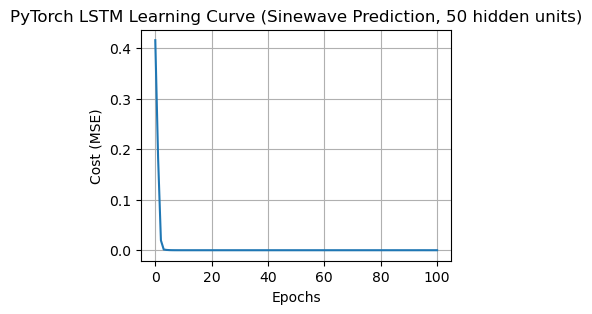

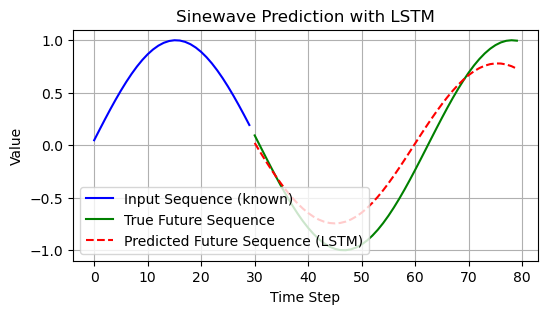

In [61]:
# 学習曲線のプロット
plt.figure(figsize=(4,3))
plt.plot(costs_sindata_lstm)
plt.xlabel(f"Epochs")
plt.ylabel("Cost (MSE)")
plt.title(f"PyTorch LSTM Learning Curve (Sinewave Prediction, {hidden_dim_sin} hidden units)")
plt.grid(True); plt.show()

# 学習済みモデルで予測してプロット
model_sindata_lstm.eval()
with torch.no_grad():
    # 1つのテストシーケンスを生成
    X_test_sin, y_test_sin_true = generate_sindata(seq_length=seq_len_sindata, num_sequences=1, predict_steps=50)
    X_test_sin_pt = torch.from_numpy(X_test_sin).to(device)
    
    # 最初の入力シーケンスで隠れ状態とセル状態を初期化
    # h_curr = torch.zeros(num_lstm_layers_sin, 1, hidden_dim_sin).to(device)
    # c_curr = torch.zeros(num_lstm_layers_sin, 1, hidden_dim_sin).to(device)
    
    # 最初のシーケンスを入力して最後の状態を得る
    _, (hn, cn) = model_sindata_lstm(X_test_sin_pt) # (hn, cn) は最後のタイムステップの状態

    # 逐次的に予測
    num_predictions_future = 50
    current_input_val = X_test_sin_pt[:, -1:, :] # 最後の既知の入力 (batch, 1, input_dim)
    predicted_sequence = []

    for _ in range(num_predictions_future):
        pred_out, (hn, cn) = model_sindata_lstm(current_input_val, (hn, cn))
        # pred_out は (batch, 1, output_dim)
        predicted_val = pred_out.item() # バッチサイズ1、シーケンス長1なのでitem()で取れる
        predicted_sequence.append(predicted_val)
        current_input_val = torch.tensor([[[predicted_val]]], dtype=torch.float32).to(device) # 次の入力として使う

# プロット
plt.figure(figsize=(6,3))
total_len_plot = seq_len_sindata + num_predictions_future
plt.plot(np.arange(seq_len_sindata), X_test_sin.ravel(), 'b-', label='Input Sequence (known)')
plt.plot(np.arange(seq_len_sindata, total_len_plot), y_test_sin_true.ravel(), 'g-', label='True Future Sequence')
plt.plot(np.arange(seq_len_sindata, total_len_plot), predicted_sequence, 'r--', label='Predicted Future Sequence (LSTM)')
plt.title("Sinewave Prediction with LSTM")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
